#  WeFarm data set - Farmer ID

This notebook processes the WeFarm data set and creates a leaderboard of the top contributors.

## Definitions

In [12]:
# Set up
from pathlib import Path

ROOT_DIR = Path('').resolve()
DATA_DIR = ROOT_DIR / 'data'
RESULTS_DIR = ROOT_DIR / 'results'
DATA_FILE = DATA_DIR / 'b0cd514b-b9cc-4972-a0c2-c91726e6d825.csv'
GRAPH_FILE = DATA_DIR / 'graph.pkl'
CSV_DELIMETER=','
QID_COL='question_id'
ATTRS=('question_language','question_topic')
FROM_COL='question_user_id'
TO_COL='response_user_id'

## Confirm directories and file

In [4]:
# Create directories if they don't exist
for directory in [DATA_DIR, RESULTS_DIR]:
    directory.mkdir(exist_ok=True)

    # print contents of data directory
    print(f"Files in '{directory}':")
    for file in directory.iterdir():
        print(f"\t{file.name}")
    print()

    print(f"Data file: {DATA_FILE}")

Files in 'C:\Users\jbhan\OneDrive\Documents\Visual Studio 2019\Projects\Python\datakit-smallholder-farmers-fall-2025\Challenge 3_Community Leaders\jayr\data':
	b0cd514b-b9cc-4972-a0c2-c91726e6d825.csv
	meeting_notes.txt
	Producers Direct DataKit Brief (external).md

Data file: C:\Users\jbhan\OneDrive\Documents\Visual Studio 2019\Projects\Python\datakit-smallholder-farmers-fall-2025\Challenge 3_Community Leaders\jayr\data\b0cd514b-b9cc-4972-a0c2-c91726e6d825.csv
Files in 'C:\Users\jbhan\OneDrive\Documents\Visual Studio 2019\Projects\Python\datakit-smallholder-farmers-fall-2025\Challenge 3_Community Leaders\jayr\results':

Data file: C:\Users\jbhan\OneDrive\Documents\Visual Studio 2019\Projects\Python\datakit-smallholder-farmers-fall-2025\Challenge 3_Community Leaders\jayr\data\b0cd514b-b9cc-4972-a0c2-c91726e6d825.csv


## Create a Multi Di Graph of the questions

In [5]:
import csv
from src.graph import MultiDiGraph

graph = MultiDiGraph()

with open(DATA_FILE, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f, delimiter=CSV_DELIMETER)

    i=0
    for row in reader:
        from_node = row[FROM_COL]
        to_node = row[TO_COL]

        i += 1
        if i > 500_000:
            break

        # Remaining columns become edge attributes
        edge_id = row[QID_COL]

        graph.add_new_edge(from_node, to_node, edge_id)

all_edges = graph.get_all_edges()
print(len(all_edges))

500000


In [6]:
import numpy as np
indegrees = []
outdegrees = []
for node in graph.nodes:
    indegrees.append(graph.in_degree(node))
    outdegrees.append(graph.out_degree(node))

print('Summary of nodes by indegree\tSummary of nodes by outdegree')
print(f'Min\t\t{min(indegrees)}\t\t{min(outdegrees)}')
print(f'25 %ile\t\t{np.quantile(indegrees, 0.25):.3f}\t\t{np.quantile(outdegrees, 0.25):.3f}')
print(f'Median\t\t{np.median(indegrees)}\t\t{np.median(outdegrees)}')
print(f'75 %ile\t\t{np.quantile(indegrees, 0.75):.3f}\t\t{np.quantile(outdegrees, 0.75):.3f}')
print(f'Max\t\t{max(indegrees)}\t\t{max(outdegrees)}')
print(f'Mean\t\t{np.mean(indegrees):.3f}\t\t{np.mean(outdegrees):.3f}')

TypeError: MultiDiGraph.in_degree() missing 1 required positional argument: 'node'

In [9]:
# Q3 + 2(Q3-Q1)
# Askers = 313
# Responders = 488
# Keep high askers or answerers
print("Number of original users", len(graph.nodes))
askers = {node for node in graph.nodes if graph.out_degree(node) > 313}
answerers = {node for node in graph.nodes if graph.in_degree(node) > 488}
keep = askers.union(answerers)
print('Users with many questions', len(askers))
print('Users with many answers', len(answerers))
graph = graph.subgraph(keep)

print("Number of qualified users", len(graph.nodes))
print("Number of qualified questions", len(graph.get_all_edges()))

Number of original users 112100
112100
2
13
14
Number of qualified users 14
Number of qualified questions 69


## Get the most askers and answerers

In [10]:
indegrees = [graph.in_degree(node) for node in graph.nodes]
nodes_by_indegree = sorted(indegrees, reverse=True)
outdegrees = [graph.out_degree(node) for node in graph.nodes]
nodes_by_outdegree = sorted(outdegrees, reverse=True)

# Summary of nodes by indegree
import numpy as np
print('Summary of nodes by indegree\tSummary of nodes by outdegree')
print(f'Min\t\t{min(nodes_by_indegree)}\t\t{min(nodes_by_outdegree)}')
print(f'Median\t\t{np.median(nodes_by_indegree)}\t\t{np.median(nodes_by_outdegree)}')
print(f'75 %ile\t\t{np.quantile(nodes_by_indegree, 0.75):.3f}\t\t{np.quantile(nodes_by_outdegree, 0.75):.3f}')
print(f'Max\t\t{max(nodes_by_indegree)}\t\t{max(nodes_by_outdegree)}')
print(f'Mean\t\t{np.mean(nodes_by_indegree):.3f}\t\t{np.mean(nodes_by_outdegree):.3f}')
print(f'Standard Deviation\t{np.std(nodes_by_indegree):.3f}\t\t{np.std(nodes_by_outdegree):.3f}')

print('Top Answerers', nodes_by_indegree[:10])
print('Top Askers', nodes_by_outdegree[:10])


Summary of nodes by indegree	Summary of nodes by outdegree
Min		0		0
Median		3.0		1.0
75 %ile		5.750		1.000
Max		23		5
Mean		4.929		1.000
Standard Deviation	5.688		1.309
Top Answerers [23, 10, 7, 6, 5, 4, 3, 3, 3, 3]
Top Askers [5, 2, 2, 1, 1, 1, 1, 1, 0, 0]


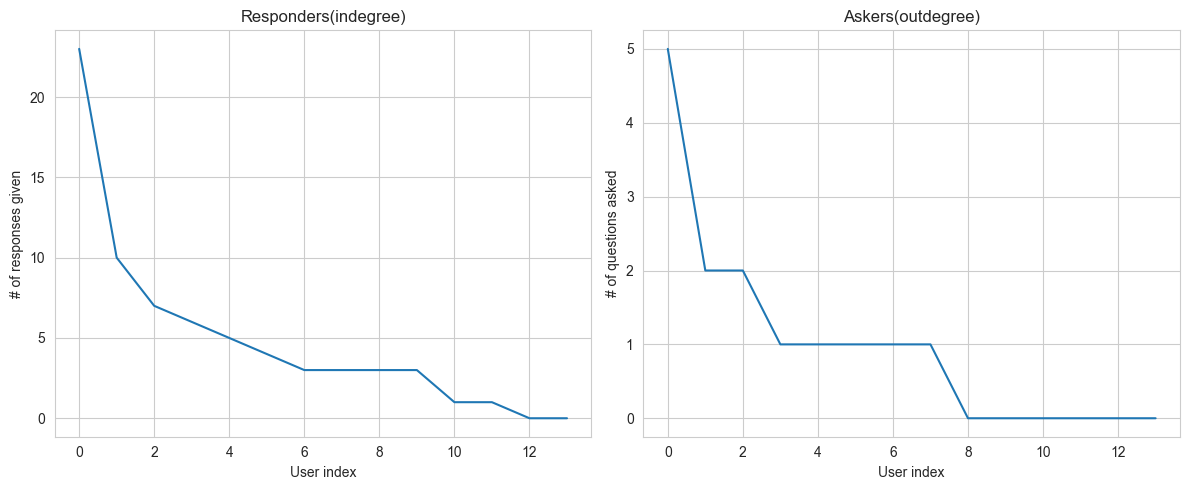

In [11]:
# Display plots side by side
import matplotlib.pyplot as plt

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))
"""ax1.hist(nodes_by_indegree, bins=100)
ax1.set_title('Frequency dist of responders')
ax1.set_xlabel('# of responses given')
ax1.set_ylabel('# of users')

ax2.hist(nodes_by_outdegree, bins=100)
ax2.set_title('Frequency dist of askers')
ax2.set_xlabel('# of questions asked')
ax2.set_ylabel('# of users')"""

ax3.plot(nodes_by_indegree)
ax3.set_title('Responders(indegree)')
ax3.set_xlabel('User index')
ax3.set_ylabel('# of responses given')

ax4.plot(nodes_by_outdegree)
ax4.set_title('Askers(outdegree)')
ax4.set_xlabel('User index')
ax4.set_ylabel('# of questions asked')

plt.tight_layout()
plt.show()

In [47]:
# Create a matrix that counts how many edges exist between each pair of nodes
all_nodes = list(graph.nodes)
edges_between_nodes = [[0 for _ in range(len(all_nodes))] for _ in range(len(all_nodes))]

all_edges = graph.get_all_edges()
print("Edges", len(all_edges))

for head, tail, qid in all_edges:
    i = all_nodes.index(head)
    j = all_nodes.index(tail)
    edges_between_nodes[i][j] += 1

edge_arr = np.array(edges_between_nodes)
print(edge_arr.shape)
# Remove row and column with low connection
edge_arr = edge_arr[edge_arr.sum(axis=1) > 11]
edge_arr = edge_arr[:, edge_arr.sum(axis=0) > 11]
print(edge_arr.shape)

# Print descriptive statistics about the matrix
print("Min", np.min(edge_arr))
print("Median", np.median(edge_arr))
print("Max", np.max(edge_arr))
print(f"Mean\t{np.mean(edge_arr):.3f}")
print(f"Standard Deviation\t{np.std(edge_arr):.3f}")

Edges 9363
(817, 817)
(291, 167)
Min 0
Median 0.0
Max 166
Mean	0.110
Standard Deviation	1.457


<Axes: >

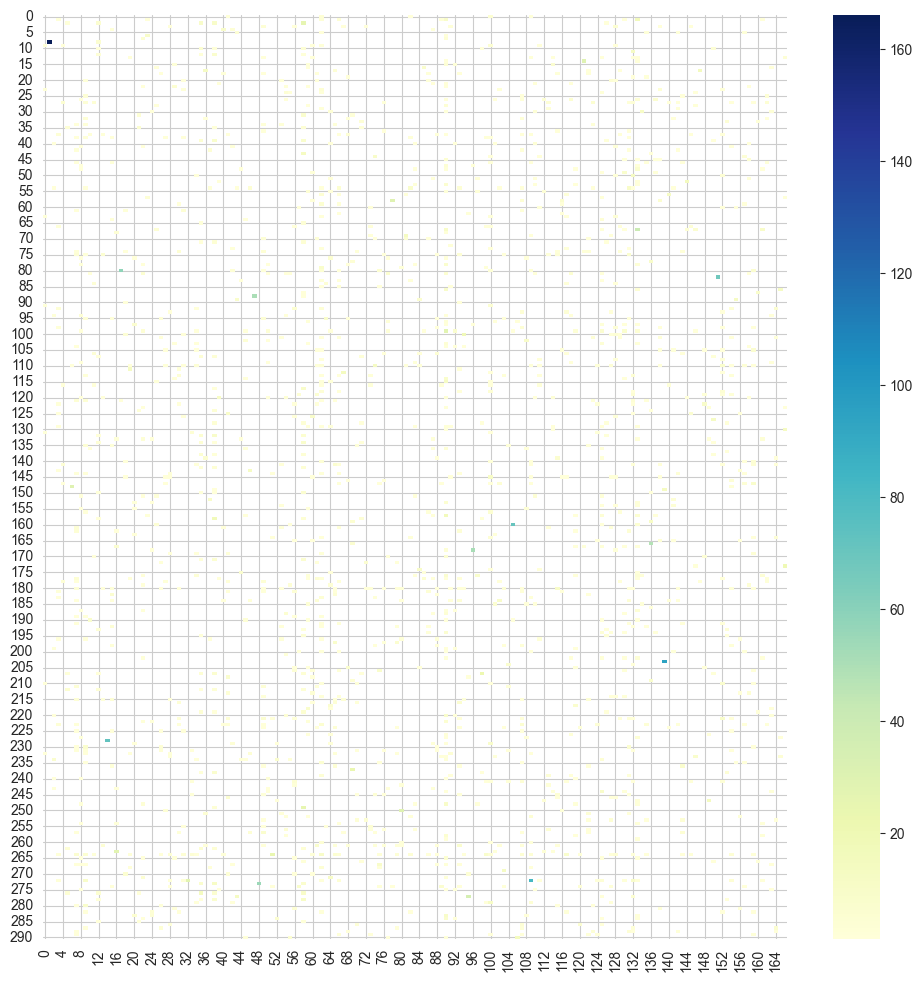

In [55]:
import seaborn as sns
cleaned_arr = edge_arr.astype(float)
cleaned_arr[cleaned_arr == 0] = np.nan

plt.figure(figsize=(12, 12))
# Color scale from yellow to blue
sns.heatmap(cleaned_arr, cmap='YlGnBu')

In [50]:
import numpy as np
import pandas as pd

# replace zeros with NaN
dense_array = edge_arr.astype(float)
dense_array[dense_array == 0] = np.nan

# Pandas will compute pairwise correlations ignoring NaN
df = pd.DataFrame(dense_array)
correlation_matrix = df.corr()  # Uses pairwise complete observations

# Threshold correlation matrix
correlation_matrix = correlation_matrix[correlation_matrix > 0.95]


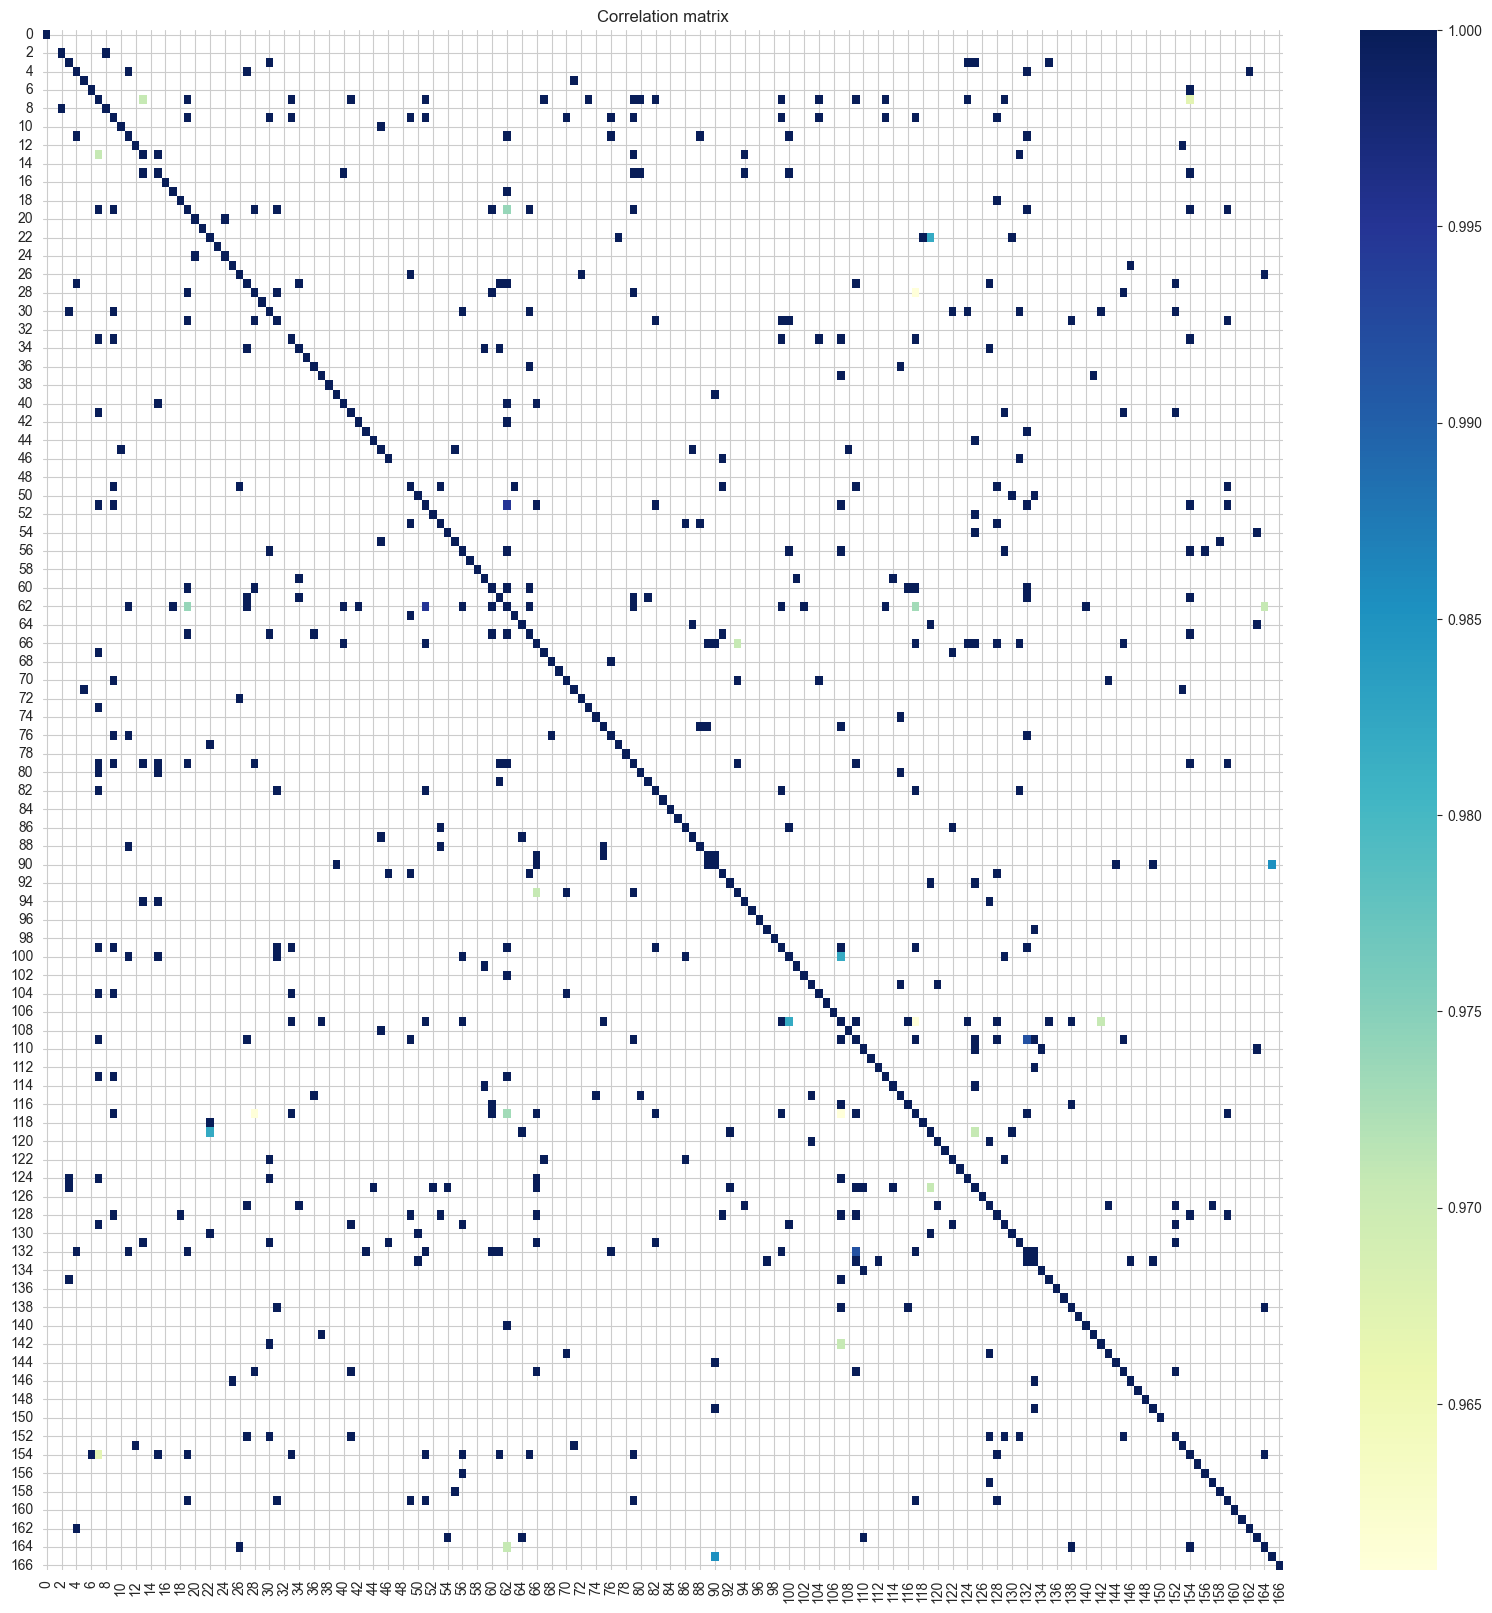

In [51]:
# Display correlation matrix
import seaborn as sns

plt.figure(figsize=(20, 20))
# Color scale from yellow to blue
sns.heatmap(correlation_matrix, cmap='YlGnBu')
plt.title('Correlation matrix')
plt.show()

In [ ]:
# Convert the matrix to a pandas DataFrame
import pandas as pd

edges_df = pd.DataFrame(edges_between_nodes, index=nodes, columns=nodes)

#Remove rows and columns with all zeros
edges_df = edges_df.loc[edges_df.sum(axis=1) > 2]
edges_df = edges_df.loc[:, edges_df.sum(axis=0) > 2]
print(edges_df.shape)

# Plot the DataFrame as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(edges_df, cmap='YlGnBu', cbar=False)
plt.title('Edges between nodes')
plt.show()

In [ ]:
print(edges_df.head(5))

## 4. Data Visualization

In [ ]:
from src.visualization import setup_plot_style, plot_distributions, plot_correlation_heatmap

# Set up visualization
%matplotlib inline
setup_plot_style()

#  visualization
plot_distributions(df)
plot_correlation_heatmap(df)

## 5. Save Results

In [ ]:
# Example: Save processed data
# processed_path = RESULTS_DIR / 'processed_data.csv'
# df.to_csv(processed_path, index=False)
# print(f'Saved processed data to {processed_path}')